ITERATIVE FUNCTION

#We have the NU as the input, and it returns Y as the output. So we want to iterate that but changing the NU

In [ ]:
for i in range (10):
    for j in range(10):

        NU = [0, 0, 0, 0, 0, 0, 0, 0] # input to model populations; this will be our set of parameters to be inferred.
        NU(i)= 100
        NU(j)= 200
        U = np.zeros((int(T/dt), P['M']))
        U[stim_start:stim_end, 0] = NU[0]   # L23E
        U[stim_start:stim_end, 1] = NU[1]   # L23I
        U[stim_start:stim_end, 2] = NU[2]   # L4E
        U[stim_start:stim_end, 3] = NU[3]   # L4I
        U[stim_start:stim_end, 4] = NU[4]   # L5E
        U[stim_start:stim_end, 5] = NU[5]   # L5I
        U[stim_start:stim_end, 6] = NU[6]   # L6E
        U[stim_start:stim_end, 7] = NU[7]   # L6I

In [ ]:
from itertools import product
import numpy as np
import scipy as sp
import pylab as plt

from scipy.stats import gamma

from DMF_model import DMF_sim, DMF_parameters
from NVC_model import NVC_sim, NVC_parameters
from LBR_model import LBR_sim, LBR_parameters

# Define the possible values for each input
values = [50, 100, 150, 200, 250]

# Initialize the array NU with all variables set to 0
NU = [0] * 8  # Assuming you have 8 elements in NU

# Define the time parameters (you should set these appropriately)
T = 1000  # Total time
dt = 1    # Time step

# Define the stimulation start and end times (you should set these appropriately)
stim_start = 100
stim_end = 200

# Iterate through all combinations of values for each element in NU
for combination in product(values, repeat=len(NU)):
    # Set the values in NU based on the current combination
    for i, val in enumerate(combination):
        NU[i] = val
    
    # Create the U array based on the current values in NU
    U = np.zeros((int(T/dt), len(NU)))
    for i in range(len(NU)):
        U[stim_start:stim_end, i] = NU[i]
    
    # Here, you can use the values in NU as inputs to your network
    # Do whatever you need with the inputs here
    
# NU will be back to [0, 0, 0, 0, 0, 0, 0, 0] after the loop

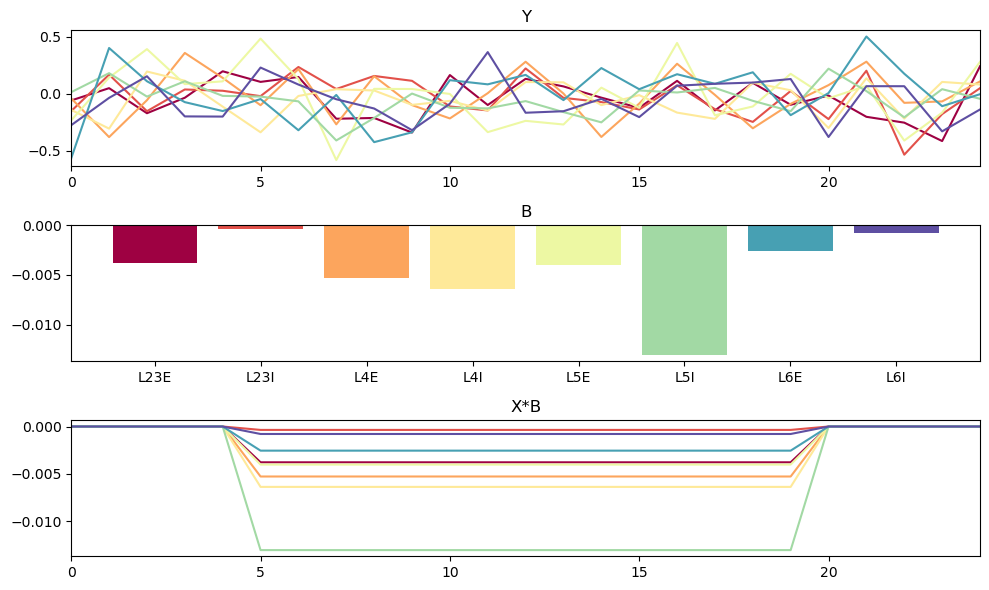

In [3]:
import numpy as np
import copy
from itertools import product
import scipy as sp
import pylab as plt

from scipy.stats import gamma

from DMF_model import DMF_sim, DMF_parameters
from NVC_model import NVC_sim, NVC_parameters
from LBR_model import LBR_sim, LBR_parameters

def HRF(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6


if __name__=='__main__':

    # DMF parameters
    P = {}
    P = DMF_parameters(P)
    P['sigma'] = 0.02  # no noise

    T  = 50     # simulation time
    dt = 1e-4   # integration step
    P['T'] = T

    # layer specific external input
    stim_start = int(10/dt)    # start of stimulation
    stim_end   = int(40/dt)    # end of stimulation
    
    # Define the possible values for each input
    values = [50, 100, 150, 200, 250]

    # Create an array of all possible combinations for each input
    input_combinations = list(product(values, repeat=2))

    # Initialize arrays to store the results
    B_results = []

    # Iterate through all combinations for each population
    for population_combinations in input_combinations:
        # Update the U array based on the current population_combinations
        U = np.zeros((int(T/dt), P['M']))
        for i, val in enumerate(population_combinations):
            U[:, i] = val

        # Simulate
        I, H, F = DMF_sim(U, P)     # I - input current, H - membrane potential, F - firing rate
        Y = I[int(1/dt):, :] - np.mean(I[int(0.5/dt):int(1/dt), :], axis=0)  # deviation from baseline during stimulation (and remove initial transient)
        Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) * 2 - 1  # normalize Y between -1 and 1

        """
        CBF and LBR model given below. This these are more complex models are commented out in the current implementation.
        After initial tests with GLM on the direct current values we can extend it to include the whole laminar bold response (LBR) model.

        # K = 4   # number of cortical depths considered for BOLD response (we keep it simple for now. more complex division of population activity can be considered later)
        # CBF = NVC_sim(neural_signal, NVC_parameters(K, P))    # obtain cerebral blood flow (CBF) from neural activity through neurvascular coupling (NVC) model.
        # # obtain BOLD signal from CBF through calibrated BOLD response (LBR) model.
        # LBR_params = LBR_parameters(K, P)
        # LBR_params['alpha_v']  = 0.35
        # LBR_params['alpha_d']  = 0.2
        # LBR_params['tau_d_de'] = 30

        # # downsample CBF to match LBR integration step
        # new_dt = 0.01
        # old_dt = P['dt']
        # lbr_dt = new_dt/old_dt
        # CBF_ = CBF[::int(lbr_dt)]
        # LBR_params['dt'] = new_dt
        # # obtain laminar bold response (LBR)
        # LBR, _, _ = LBR_sim(CBF_, LBR_params)
        """

        ### GLM ANALYSIS ###
        # i.e. how to scale the betas (B) to obtain the original signal (I_stim) given the predicted signal (pred_BOLD)

        # convolve condition with hemodynamic response function (HRF) function
        TR = 2                      # interval between MRI scan acquisitions in seconds
        x = np.arange(0, 40, TR)    # time vector at which BOLD signal is sampled
        hrf = HRF(x)                # hemodynamic response function (HRF) function

        # create condition vector for GLM analysis
        condition = np.zeros((int(T/dt)))
        condition[stim_start:stim_end] = 1

        X = np.convolve(condition, hrf)[:len(condition)]      # predicted BOLD signal
        X = X[int(1/dt):]

        # sample X and Y with TR resolution
        X = X[::int(TR/dt)]
        Y = Y[::int(TR/dt), :]

        # convolve condition with HRF to obtain predicted BOLD signal
        X = (X - np.min(X)) / (np.max(X) - np.min(X))       # normalize X between 0 and 1
        X = np.tile(X, (Y.shape[1], 1)).T   # repeat for each population (i.e. column of Y)

        # scale betas to obtain original signal (Y = X*B)
        B = (np.linalg.pinv(X @ X.T) @ X).T @ Y
        B = B[0, :] 

        # Append the B values to the results
        B_results.append(B)

    # Now, B_results contains the scaling factors for each population for all combinations of input values.
    populations = np.array(['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'])
    colors      = plt.cm.Spectral(np.linspace(0, 1, len(populations)))
    plt.figure(figsize=(10, 6))
    plt.subplot(311)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Spectral(np.linspace(0, 1, 8))))
    plt.title('Y')
    plt.plot(Y)
    plt.xlim([0, len(Y)-1])
    plt.subplot(312)
    plt.title('B')
    plt.bar(populations, B, color=colors)
    plt.subplot(313)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Spectral(np.linspace(0, 1, 8))))
    plt.title('X*B')
    plt.plot(X*B)
    plt.xlim([0, len(X)-1])
    plt.tight_layout()
    plt.show()
    # You can analyze or use these results as needed.


    """
    NU - the vector which will be the main parameters to be inferred.
    B  - the main observable statistic which will be used to infer the parameters.

    we now obtain B values for each population and not for each layer. 
    This should be enough for initial tests, later we could include the whole LBR model with a BOLD signal per layer.
    """


In [5]:
B_results

[array([ 0.0006166 ,  0.00188613,  0.00051361,  0.00020722, -0.00110641,
        -0.0046164 ,  0.01076707, -0.00523838]),
 array([-5.52933281e-03,  3.70518918e-05, -1.02028922e-02,  5.05371275e-03,
        -2.94965307e-03,  4.30635111e-05,  1.34376632e-03, -7.30936074e-03]),
 array([0.01379345, 0.01155504, 0.00569537, 0.0069259 , 0.01794859,
        0.01164575, 0.0179085 , 0.01015029]),
 array([ 0.00922941, -0.00287319,  0.00378815,  0.02121738, -0.00396067,
         0.00571281,  0.00409794,  0.00809814]),
 array([-7.47143086e-03, -5.94165519e-06,  6.37853629e-04, -2.26946863e-03,
        -1.50749847e-02, -5.23574262e-03, -1.06256077e-02, -6.45718052e-03]),
 array([-0.0002445 , -0.00366806,  0.0022374 ,  0.00148436,  0.00506233,
         0.00999401, -0.01133021, -0.00228247]),
 array([-0.00620818, -0.01234182, -0.0056441 , -0.00339205, -0.00861902,
        -0.01479357, -0.01153253,  0.00078824]),
 array([ 0.00124813, -0.00384362,  0.00505085,  0.00469346,  0.01088397,
        -0.002683

Current: NU, more combinations. input ranges from 0 to 300 in incrememnts of possibly 25mA? add noise with the same combinations, sample around the value of th einput (randomly sampled as a normal distribution), 